In [1]:
# import modules
%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler
_colc = matplotlib.rcParams['axes.prop_cycle'].concat(cycler(color=['blue', 'black']))
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

In [2]:
%%time

import chempl
from chempl import (cs, run_one_model, get_total_charge,
                    get_phy_params_default, N_H_to_Av, Av_to_N_H,
                    N_H_to_ngas, Td_from_Av, chem2tex, printFormationDestruction)

CPU times: user 7.79 ms, sys: 6.94 ms, total: 14.7 ms
Wall time: 860 ms


# A minimal working example

In [3]:
%%time

# Load the reactions and initial abundances, and prepare for the solver.
# Note that the .prepare().set_solver() are necessary for the initial setup.

model = chempl.ChemModel(
    fReactions=b'rate12_noSurf_only_H2_formation.dat',
    fInitialAbundances=b'initial_abundances.dat',
    phy_params=
    {b'Av': 10.0,
     b'G0_UV': 1.0,
     b'Ncol_H2': 1e22,
     b'T_dust': 10.0,
     b'T_gas': 10.0,
     b'chemdesorption_factor': 0.05,
     b'chi_cosmicray': 1.0,
     b'dust2gas_mass': 1e-2,
     b'dust_albedo': 0.6,
     b'dust_material_density': 2.0,
     b'dust_radius': 0.1e-4,
     b'dust_site_density': 1e15,
     b'dv_km_s': 1.0,
     b'mean_mol_weight': 1.4,
     b'n_gas': 1e5}).prepare().set_solver()

CPU times: user 113 ms, sys: 3.11 ms, total: 117 ms
Wall time: 116 ms


In [4]:
%%time

print('Number of reactions', len(model.reactions))
print('Number of species', len(model.name2idx))

Number of reactions 6179
Number of species 470
CPU times: user 10.5 ms, sys: 2.24 ms, total: 12.7 ms
Wall time: 12.3 ms


In [7]:
%%time

t = 0.0 # Initial time, in seconds
dt = 0.1 # Initial time step
tRatio = 1.1 # Ratio between time steps
tMax = 1e6 * cs.phy_SecondsPerYear # Targeted final time
nMax = 2000 # Number of time steps (estimated)
store = {'t': [], 'y': []} # Storage for the intermediate steps
y = model.abundances # Initial abundances as loaded in the setup

for i in range(nMax):
    t, y = model.update(y, t=t, dt=dt)
    store['t'].append(t)
    store['y'].append(y)
    if t >= tMax:
        break
    dt *= tRatio
    if t+dt > tMax:
        dt = tMax - t

'The actual number of time steps is:', len(store['t'])

CPU times: user 3.97 s, sys: 6.39 ms, total: 3.98 s
Wall time: 3.98 s


('The actual number of time steps is:', 327)

<IPython.core.display.Javascript object>


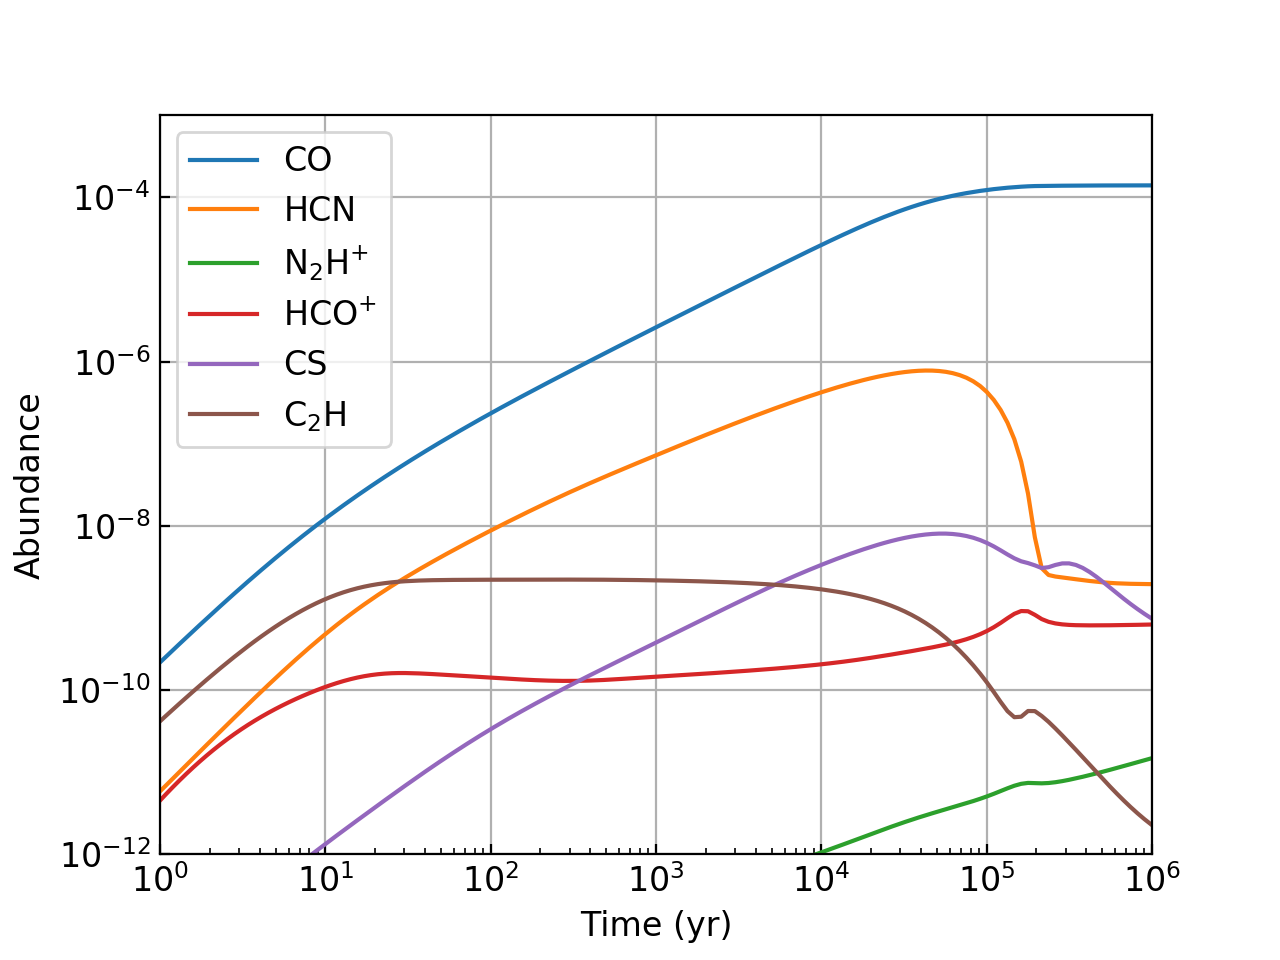

CPU times: user 26.5 ms, sys: 4.17 ms, total: 30.7 ms
Wall time: 28.6 ms


In [8]:
%%time

t = [_/cs.phy_SecondsPerYear for _ in store['t']]

molnames = [b'CO', b'HCN', b'N2H+', b'HCO+', b'CS', b'C2H']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim((1, 1e6))
ax.set_ylim((1e-12, 1e-3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Abundance')
ax.grid()

for name in molnames:
    idx = model.name2idx[name]
    y = [_[idx] for _ in store['y']]
    ax.plot(t, y, label=chem2tex(name.decode()))
_ = ax.legend()

In [7]:
%%time

# Now change some physical parameters to new values.

model.set_phy_param(b'n_gas', 1e3)
model.set_phy_param(b'T_gas', 40.0)
model.set_phy_param(b'T_dust', 40.0)
model.set_phy_param(b'Av', 2.0)
model.reset_solver()

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 21.2 µs


In [8]:
%%time

# Show that they are actually changed
model.get_all_phy_params()

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 21 µs


{b'Av': 2.0,
 b'G0_UV': 1.0,
 b'Ncol_CO': 0.0,
 b'Ncol_H': 0.0,
 b'Ncol_H2': 1e+22,
 b'T_dust': 40.0,
 b'T_gas': 40.0,
 b'chemdesorption_factor': 0.05,
 b'chi_Xray': 0.0,
 b'chi_cosmicray': 1.0,
 b'dust2gas_mass': 0.01,
 b'dust2gas_num': 2.7951629199813483e-12,
 b'dust_albedo': 0.6,
 b'dust_crosssec': 3.141592653589794e-10,
 b'dust_material_density': 2.0,
 b'dust_radius': 1e-05,
 b'dust_site_density': 1000000000000000.0,
 b'dv_km_s': 1.0,
 b'mean_mol_weight': 1.4,
 b'n_gas': 1000.0,
 b't_max_year': 0.0,
 b'v_km_s': 0.0}

In [9]:
%%time

t = 0.0
dt = 0.1
tRatio = 1.1
tMax = 1e6 * cs.phy_SecondsPerYear # in seconds
nMax = 2000
store = {'t': [], 'y': []}
y = model.abundances
for i in range(nMax):
    t, y = model.update(y, t=t, dt=dt)
    store['t'].append(t)
    store['y'].append(y)
    if t >= tMax:
        break
    dt *= tRatio
    if t+dt > tMax:
        dt = tMax - t
    
'The actual number of time steps is:', len(store['t'])

CPU times: user 2.8 s, sys: 14.1 ms, total: 2.81 s
Wall time: 2.81 s


('The actual number of time steps is:', 327)

<IPython.core.display.Javascript object>


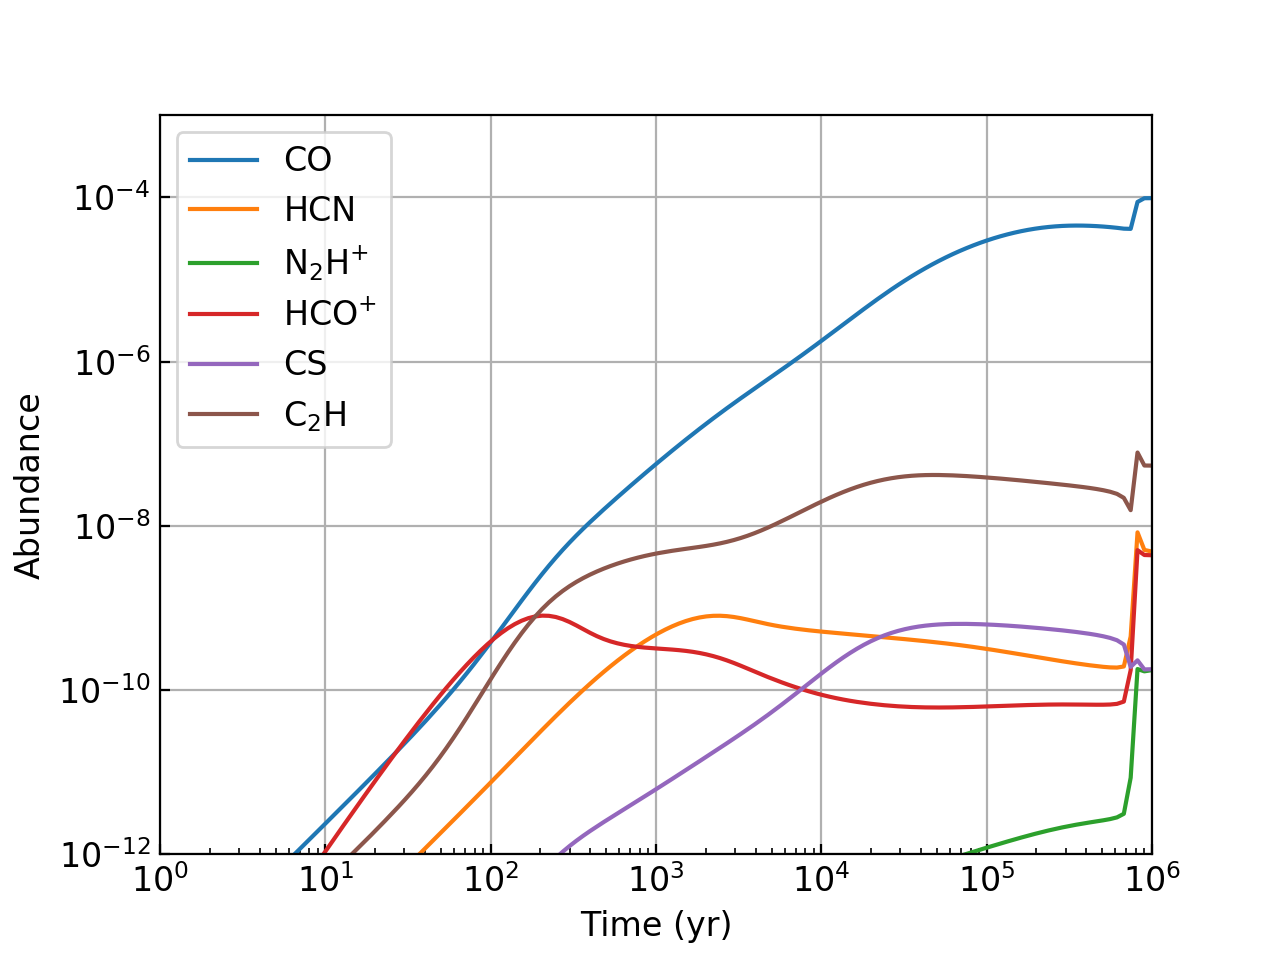

In [10]:
t = [_/cs.phy_SecondsPerYear for _ in store['t']]

molnames = [b'CO', b'HCN', b'N2H+', b'HCO+', b'CS', b'C2H']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim((1, 1e6))
ax.set_ylim((1e-12, 1e-3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Abundance')
ax.grid()

for name in molnames:
    idx = model.name2idx[name]
    y = [_[idx] for _ in store['y']]
    ax.plot(t, y, label=chem2tex(name.decode()))
ax.legend()

# A simple wrapper for the boilerplate steps

In [11]:
phy_params = get_phy_params_default()
print(phy_params)

{b'Av': 20.0, b'G0_UV': 1.0, b'Ncol_H2': 4e+22, b'T_dust': 15.0, b'T_gas': 15.0, b'chemdesorption_factor': 0.05, b'chi_Xray': 0.0, b'chi_cosmicray': 1.0, b'dust2gas_mass': 0.01, b'dust_albedo': 0.6, b'dust_material_density': 2.0, b'dust_radius': 1e-05, b'dust_site_density': 1000000000000000.0, b'dv_km_s': 1.0, b'v_km_s': 14.5, b'mean_mol_weight': 1.4, b'n_gas': 50000.0, b't_max_year': 10000000.0}


In [12]:
phy_params[b'n_gas'] = 1e13
phy_params[b'T_gas'] = 10.0
phy_params[b'T_dust'] = 10.0

In [13]:
res = chempl.run_one_model(
    p={'model_id': 0,
       'y0': model.abundances,
       't0': 0.0,
       'dt0': 1.0,
       't_ratio': 1.1,
       'tmax': 1e6*cs.phy_SecondsPerYear,
       'nmax': 2000,
       'phy_params': phy_params
      },
    model=model
)

Solver: 0 finished: 10.519635 seconds elapsed


In [14]:
res.keys()

dict_keys(['ts', 'ys', 'phy_s', 'finished', 'y', 't', 'dt'])

<IPython.core.display.Javascript object>


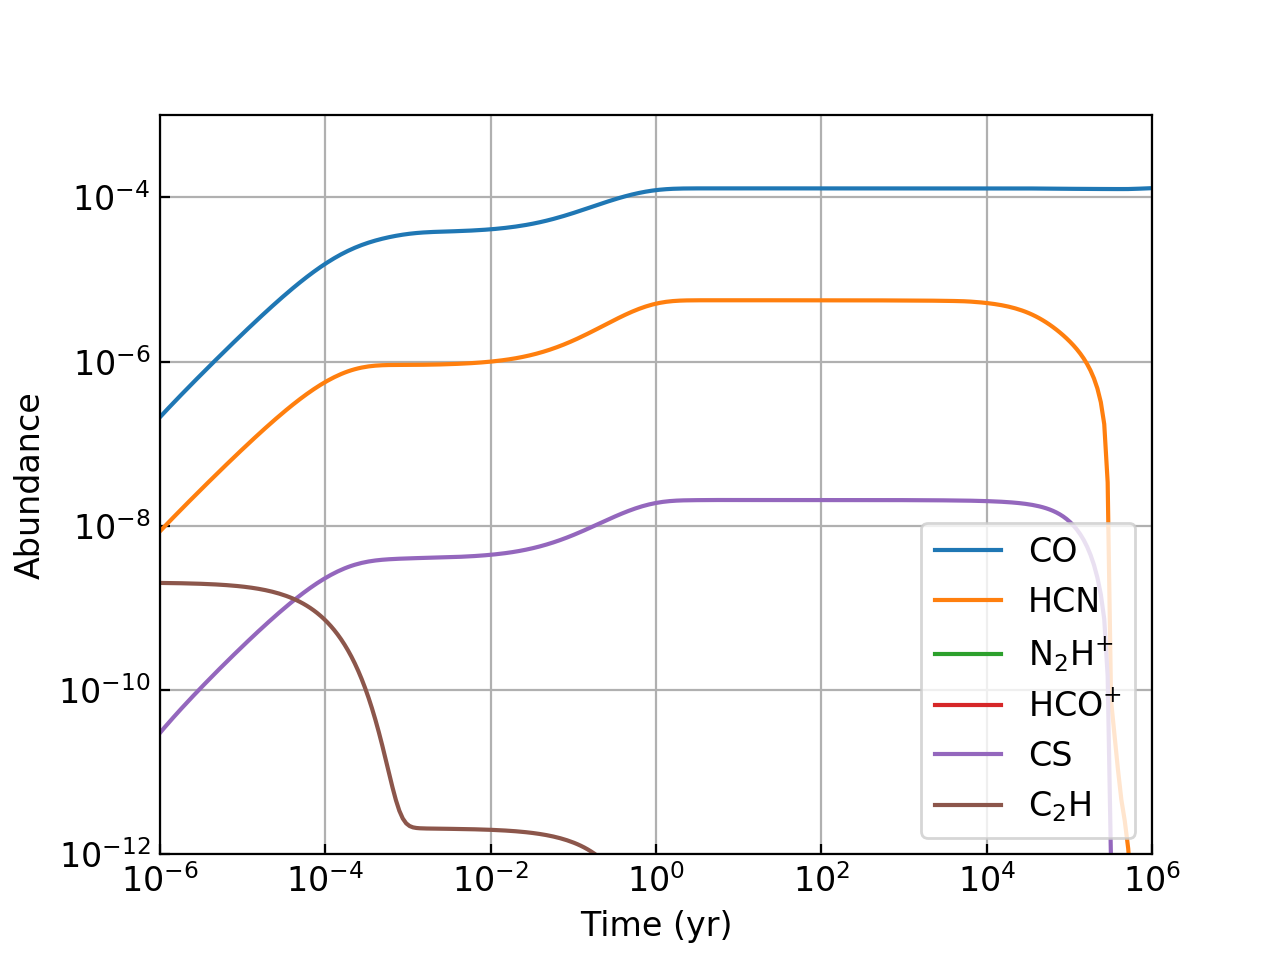

In [15]:
t = [_/cs.phy_SecondsPerYear for _ in res['ts']]

molnames = [b'CO', b'HCN', b'N2H+', b'HCO+', b'CS', b'C2H']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim((1e-6, 1e6))
ax.set_ylim((1e-12, 1e-3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Abundance')
ax.grid()

for name in molnames:
    idx = model.name2idx[name]
    y = [_[idx] for _ in res['ys']]
    ax.plot(t, y, label=chem2tex(name.decode()))
ax.legend()

# Try with a network containing adsorption and desorption

In [16]:
%%time

# Load the reactions and initial abundances, and prepare for the solver.
# Note that the .prepare().set_solver() are necessary for the initial setup.

model = chempl.ChemModel(
    fReactions=b'rate12_combined_no_surface_reaction.dat',
    fInitialAbundances=b'initial_abundances.dat')
phy_params = get_phy_params_default()
phy_params[b'n_gas'] = 1e13
phy_params[b'T_gas'] = 10.0
phy_params[b'T_dust'] = 10.0

res = chempl.run_one_model(
    p={'model_id': 0,
       'y0': model.abundances,
       't0': 0.0,
       'dt0': 1.0,
       't_ratio': 1.1,
       'tmax': 1e6*cs.phy_SecondsPerYear,
       'nmax': 2000,
       'phy_params': phy_params
      },
    model=model
)

Solver: 0 finished: 12.181669 seconds elapsed
CPU times: user 12.4 s, sys: 79.6 ms, total: 12.4 s
Wall time: 12.3 s


<IPython.core.display.Javascript object>


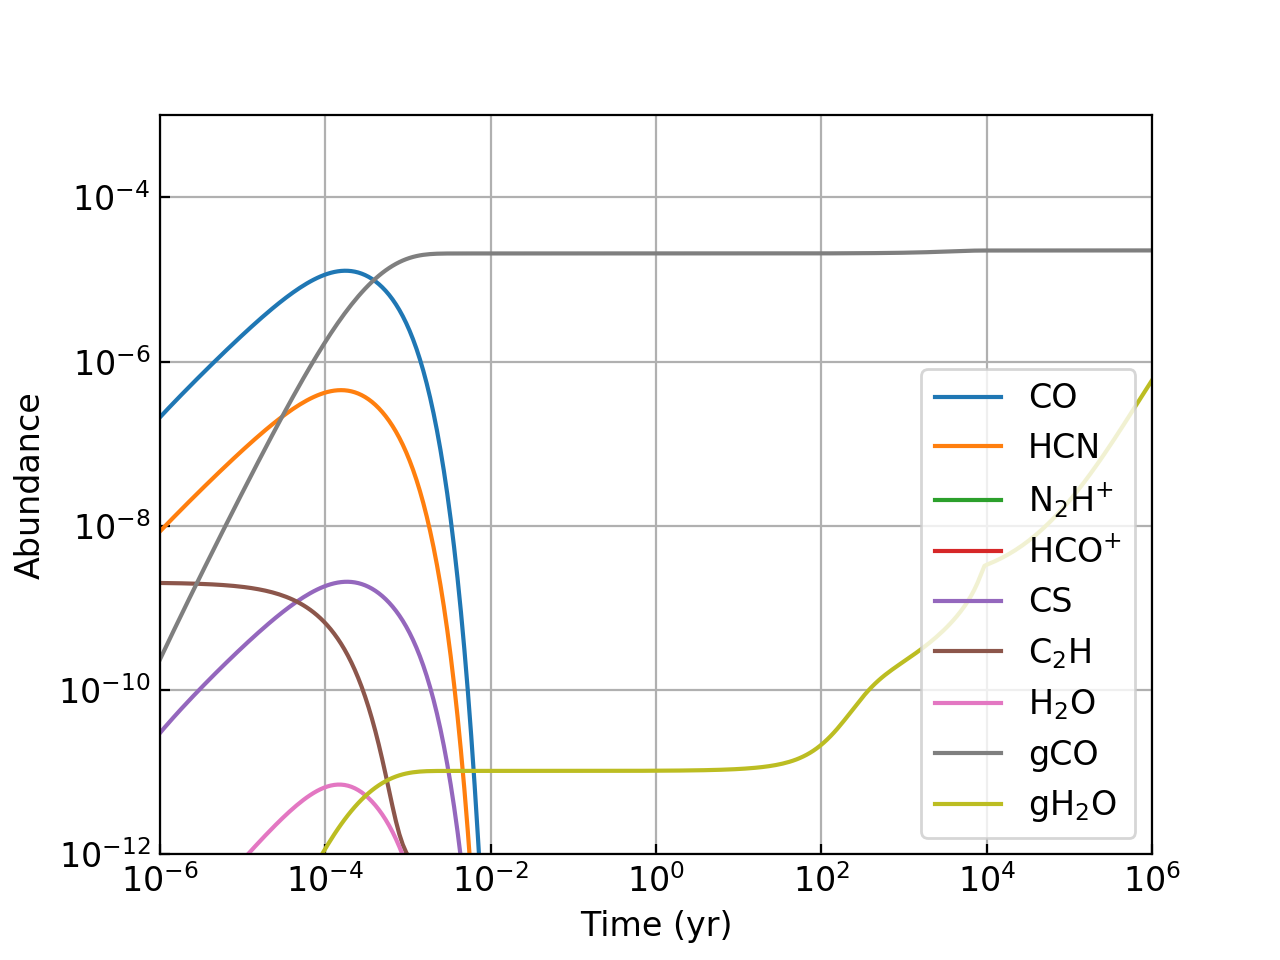

In [17]:
t = [_/cs.phy_SecondsPerYear for _ in res['ts']]

molnames = [b'CO', b'HCN', b'N2H+', b'HCO+', b'CS', b'C2H', b'H2O', b'gCO', b'gH2O']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim((1e-6, 1e6))
ax.set_ylim((1e-12, 1e-3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Abundance')
ax.grid()

for name in molnames:
    idx = model.name2idx[name]
    y = [_[idx] for _ in res['ys']]
    ax.plot(t, y, label=chem2tex(name.decode()))
ax.legend()

# Try with a network containing surface reactions

In [18]:
%%time

# Load the reactions and initial abundances, and prepare for the solver.
# Note that the .prepare().set_solver() are necessary for the initial setup.

model = chempl.ChemModel(
    fReactions=b'rate12_combined.dat',
    fInitialAbundances=b'initial_abundances.dat')
phy_params = get_phy_params_default()
phy_params[b'n_gas'] = 1e13
phy_params[b'T_gas'] = 10.0
phy_params[b'T_dust'] = 10.0

res = chempl.run_one_model(
    p={'model_id': 0,
       'y0': model.abundances,
       't0': 0.0, 'dt0': 1.0, 't_ratio': 1.1,
       'tmax': 1e6*cs.phy_SecondsPerYear,
       'nmax': 2000,
       'phy_params': phy_params
      },
    model=model
)

Solver: 0 finished: 17.547433 seconds elapsed
CPU times: user 17.7 s, sys: 102 ms, total: 17.8 s
Wall time: 17.7 s


In [19]:
print('Number of reactions', len(model.reactions))
print('Number of species', len(model.name2idx))

Number of reactions 7721
Number of species 703


<IPython.core.display.Javascript object>


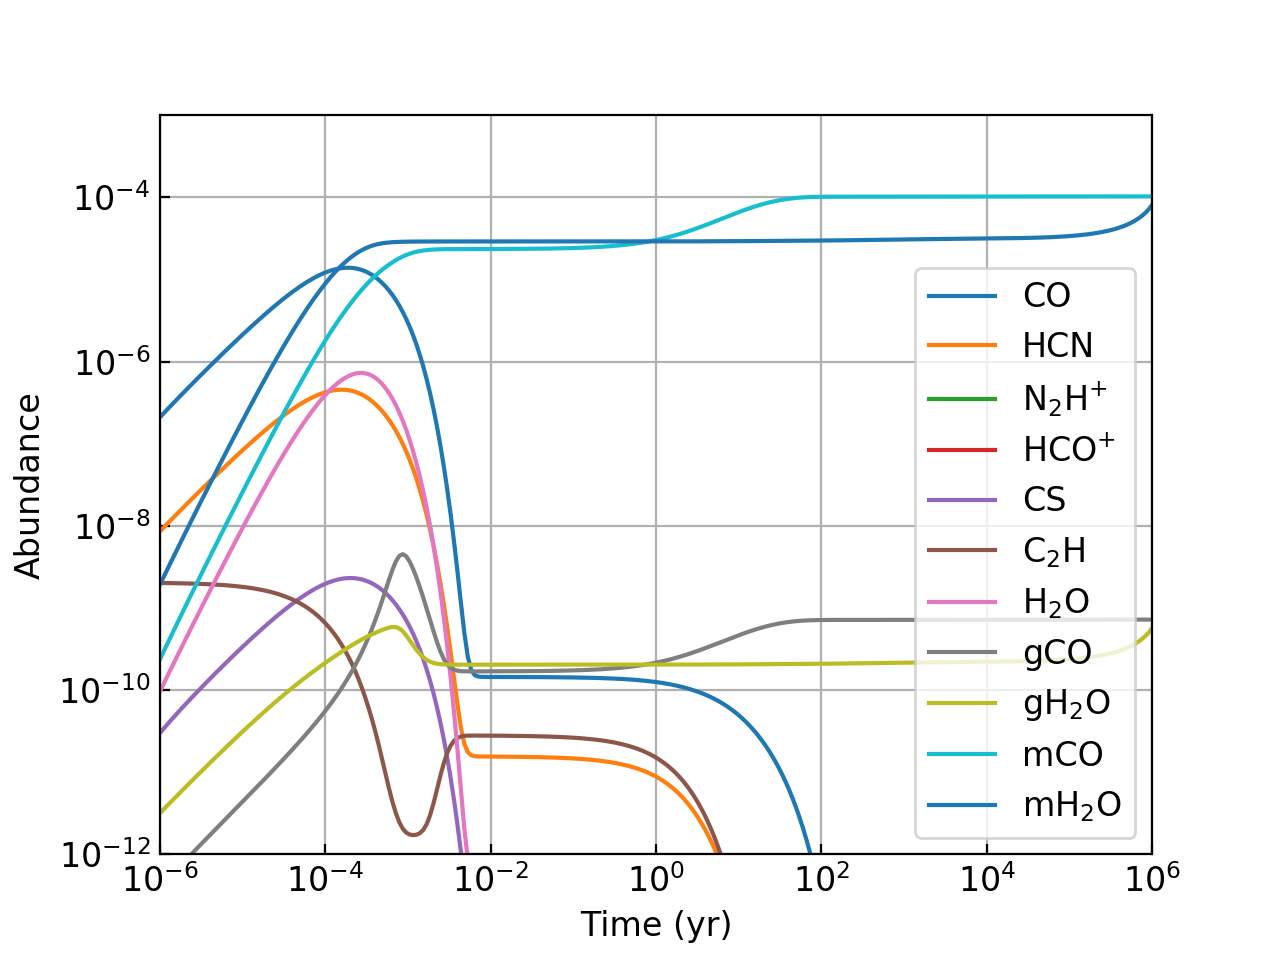

In [20]:
t = [_/cs.phy_SecondsPerYear for _ in res['ts']]

molnames = [b'CO', b'HCN', b'N2H+', b'HCO+', b'CS', b'C2H', b'H2O', b'gCO', b'gH2O', b'mCO', b'mH2O']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim((1e-6, 1e6))
ax.set_ylim((1e-12, 1e-3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Abundance')
ax.grid()

for name in molnames:
    idx = model.name2idx[name]
    y = [_[idx] for _ in res['ys']]
    ax.plot(t, y, label=chem2tex(name.decode()))
ax.legend()

In [21]:
# Try with lower density

phy_params[b'n_gas'] = 1e6

res = chempl.run_one_model(
    p={'model_id': 0,
       'y0': model.abundances,
       't0': 0.0, 'dt0': 1.0, 't_ratio': 1.1,
       'tmax': 1e6*cs.phy_SecondsPerYear,
       'nmax': 2000,
       'phy_params': phy_params
      },
    model=model
)

Solver: 0 finished: 11.190309 seconds elapsed


<IPython.core.display.Javascript object>


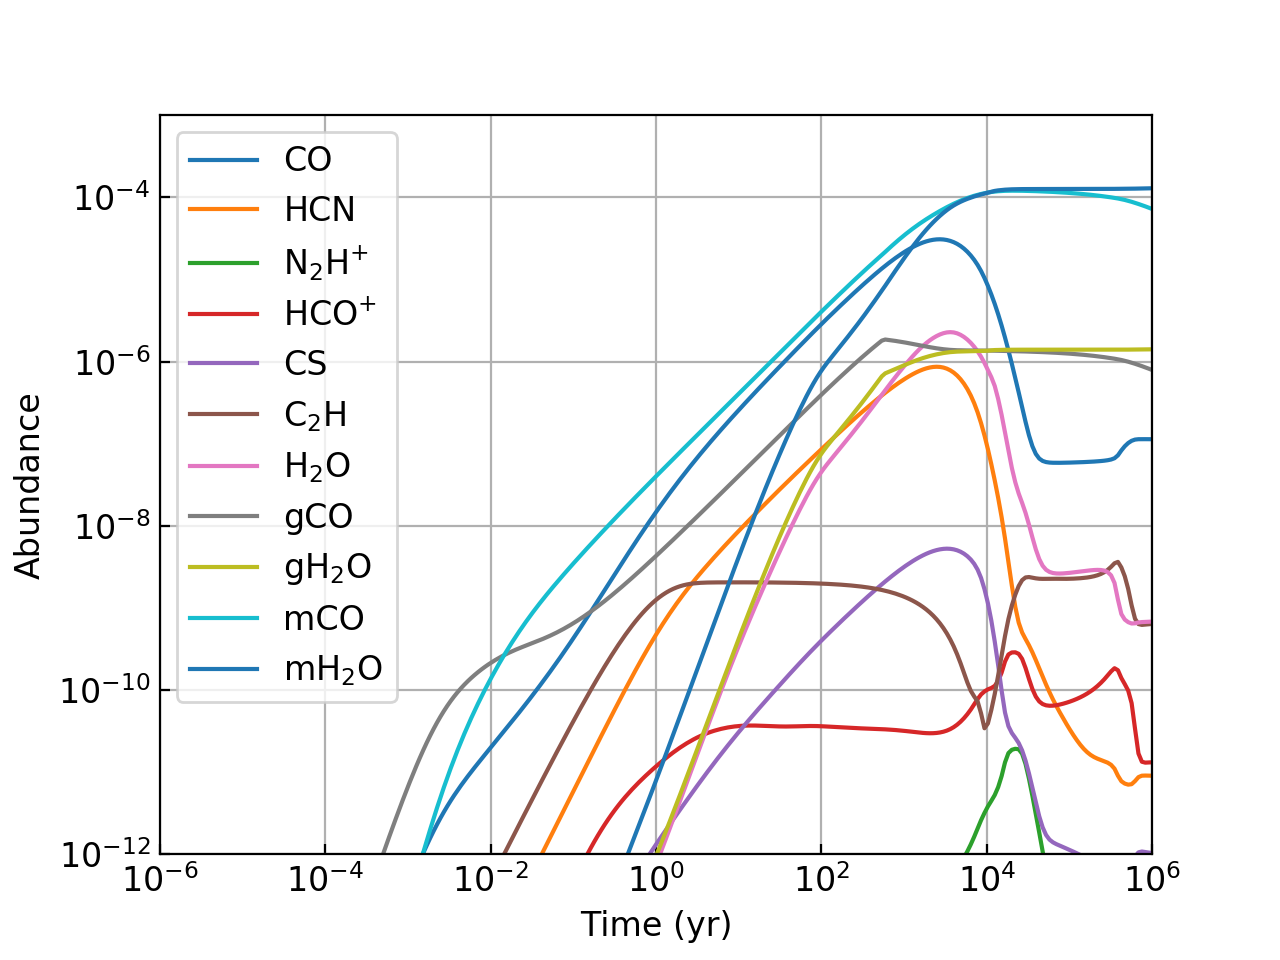

In [22]:
t = [_/cs.phy_SecondsPerYear for _ in res['ts']]

molnames = [b'CO', b'HCN', b'N2H+', b'HCO+', b'CS', b'C2H', b'H2O', b'gCO', b'gH2O', b'mCO', b'mH2O']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim((1e-6, 1e6))
ax.set_ylim((1e-12, 1e-3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Abundance')
ax.grid()

for name in molnames:
    idx = model.name2idx[name]
    y = [_[idx] for _ in res['ys']]
    ax.plot(t, y, label=chem2tex(name.decode()))
ax.legend()

# Notes on the provided reaction networks

- rate12_only_gas_phase_isotopized_driven.dat: a large network containing surface reactions and deuterium
- rate12_combined_no_surface_reaction.dat: adsorption and desorption are included, but surface reactions are not
- rate12_noSurf_only_H2_formation.dat: adsorption and desorption not included, except for the formation of H2
- rate12_combined.dat: adsorption, desorption, and surface reactions are included

# Miscellaneous

In [3]:
model = chempl.ChemModel(
    fReactions=b'rate12_noSurf_only_H2_formation.dat',
    ).prepare().set_solver().clearAbundances().setAbundanceByDict({
    b'H':   1.0,
    b'He':  0.1,
    b'C':   3.54e-4,
    b'N':   6.31e-5,
    b'O':   3.20e-4,
    b'S':   1.86e-5,
    b'Si':  8.00e-9,
    b'Na':  2.04e-6,
    b'Mg':  2.40e-5,
    b'Fe':  3.24E-5,
    b'P':   3.27E-7})

phy_params={
    b'Av': 10.0,
    b'G0_UV': 1.0,
    b'Ncol_H2': 1e22,
    b'T_dust': 60.0,
    b'T_gas': 60.0,
    b'chemdesorption_factor': 0.05,
    b'chi_cosmicray': 1.0,
    b'dust2gas_mass': 1e-2,
    b'dust_albedo': 0.6,
    b'dust_material_density': 2.0,
    b'dust_radius': 0.1e-4,
    b'dust_site_density': 1e15,
    b'dv_km_s': 1.0,
    b'mean_mol_weight': 1.4,
    b'n_gas': 1e5}

res = chempl.run_one_model(
    p={'model_id': 0,
       'y0': model.abundances,
       't0': 0.0, 'dt0': 1.0, 't_ratio': 1.02,
       'tmax': 1e6*cs.phy_SecondsPerYear,
       'nmax': 2000,
       'phy_params': phy_params
      },
    model=model
)

Solver: 0 finished: 3.849977 seconds elapsed


<IPython.core.display.Javascript object>


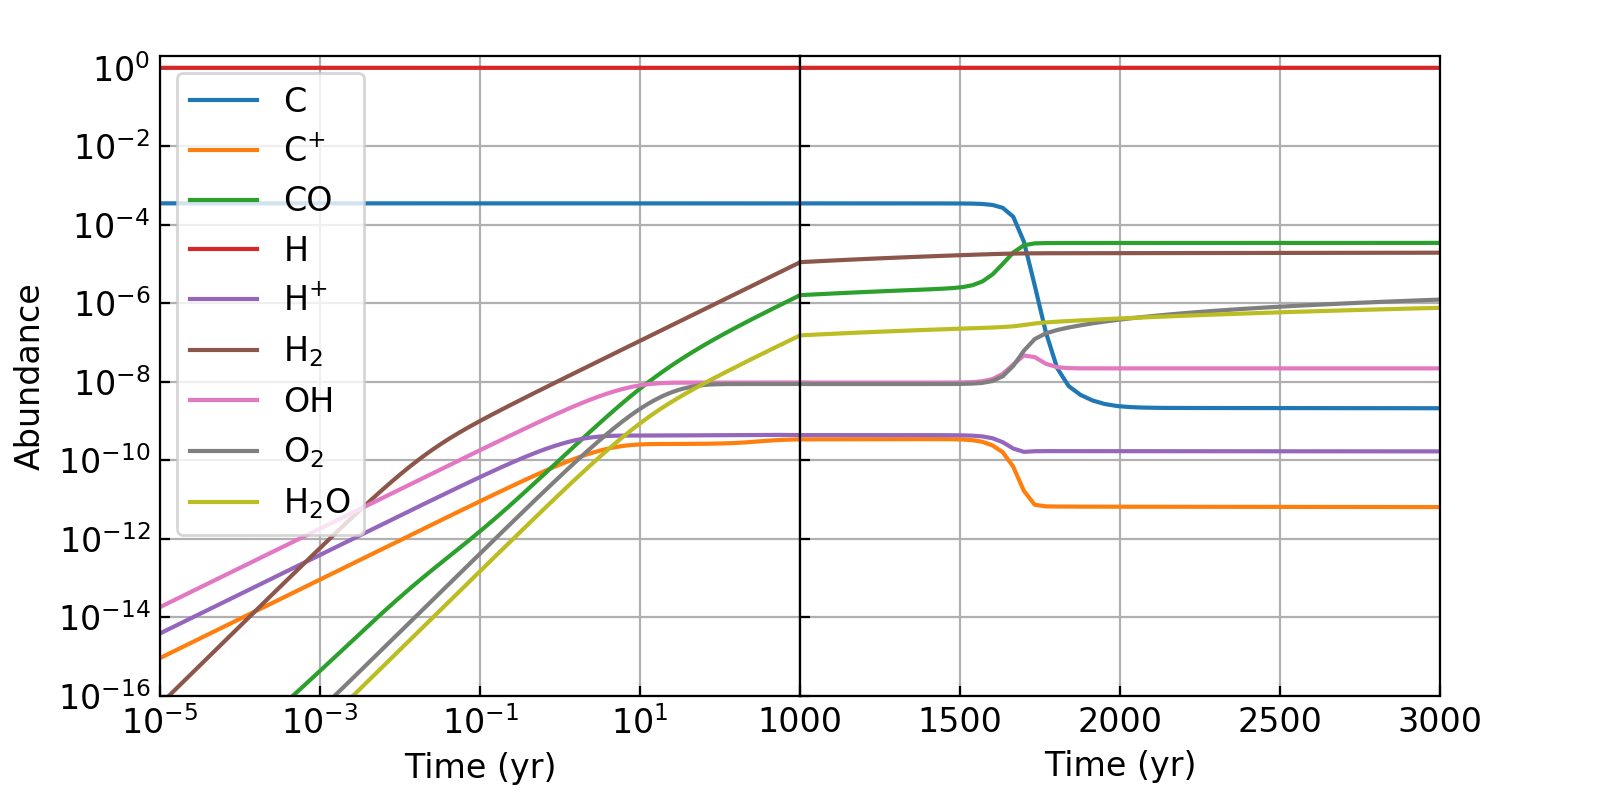

CPU times: user 105 ms, sys: 6.84 ms, total: 112 ms
Wall time: 114 ms


In [4]:
%%time

t = [_/cs.phy_SecondsPerYear for _ in res['ts']]

#molnames = [b'CO', b'HCN', b'N2H+', b'HCO+', b'CS', b'C2H']
molnames = [b'C', b'C+', b'CO', b'H', b'H+', b'H2', b'OH', b'O2', b'H2O']

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0.1,0.13,0.4,0.8])
ax.set_xlim((1e-5, 0.999e3))
ax.set_ylim((1e-16, 2))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Abundance')
ax.grid()

for name in molnames:
    idx = model.name2idx[name]
    y = [_[idx] for _ in res['ys']]
    ax.plot(t, y, label=chem2tex(name.decode()))
ax.legend()

ax = fig.add_axes([0.5,0.13,0.4,0.8])
ax.set_xlim((1e3, 3e3))
ax.set_ylim((1e-16, 2))
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlabel('Time (yr)')
ax.grid()
ax.set_yticklabels([])

for name in molnames:
    idx = model.name2idx[name]
    y = [_[idx] for _ in res['ys']]
    ax.plot(t, y, label=chem2tex(name.decode()))


In [5]:
chempl.printFormationDestruction(b'C', model, res, tmin=1.2e3, tmax=1.7e3, nstep=5)

Time      total_f   total_d   tscale_n  tscale_f tscale_d Tg    Td    ngas     y        tidx
1.288e+03 3.561e-16 4.101e-16 -2.07e+05 3.13e+04 2.72e+04 60.00 60.00 1.00e+05 3.52e-04 1035
3.513e-16 H + CH  ->  C + H2 [1.31e-10, 0.0, 80.0] 5373
-3.519e-16 H + C  ->  CH [1e-17, 0.0, 0.0] 6118
Time      total_f   total_d   tscale_n  tscale_f tscale_d Tg    Td    ngas     y        tidx
1.422e+03 3.563e-16 5.125e-16 -7.14e+04 3.13e+04 2.18e+04 60.00 60.00 1.00e+05 3.52e-04 1040
3.510e-16 H + CH  ->  C + H2 [1.31e-10, 0.0, 80.0] 5373
-3.515e-16 H + C  ->  CH [1e-17, 0.0, 0.0] 6118
Time      total_f   total_d   tscale_n  tscale_f tscale_d Tg    Td    ngas     y        tidx
1.570e+03 3.878e-16 1.160e-14 -9.63e+02 2.78e+04 9.30e+02 60.00 60.00 1.00e+05 3.40e-04 1045
3.407e-16 H + CH  ->  C + H2 [1.31e-10, 0.0, 80.0] 5373
-1.762e-15 C + C7H2  ->  C8H + H [8.4e-10, 0.0, 0.0] 5152
-1.473e-15 C + C9H2  ->  C10H + H [2.9e-10, -0.08, 0.0] 5158
-1.347e-15 C + C6H2  ->  C7H + H [7.4e-10, 0.0, 0.0] 5149
-

In [6]:
chempl.printFormationDestruction(b'CO', model, res, tmin=1.2e3, tmax=1.7e3, nstep=5)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
1.288e+03 5.258e-17 9.127e-19 1.28e+03 1.26e+03 7.25e+04 60.00 60.00 1.00e+05 2.09e-06 1035
3.375e-17 C + OH  ->  CO + H [1e-10, 0.0, 0.0] 5198
1.399e-17 C + O2  ->  CO + O [5.56e-11, 0.41, -26.9] 5195
-9.110e-19 He+ + CO  ->  O + C+ + He [1.6e-09, 0.0, 0.0] 3430
Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
1.422e+03 6.340e-17 9.232e-19 1.18e+03 1.16e+03 7.95e+04 60.00 60.00 1.00e+05 2.32e-06 1040
3.375e-17 C + OH  ->  CO + H [1e-10, 0.0, 0.0] 5198
1.399e-17 C + O2  ->  CO + O [5.56e-11, 0.41, -26.9] 5195
6.031e-18 O + C11  ->  CO + C10 [1e-10, 0.0, 0.0] 5553
-9.213e-19 He+ + CO  ->  O + C+ + He [1.6e-09, 0.0, 0.0] 3430
Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
1.570e+03 1.124e-15 5.658e-19 1.02e+02 1.02e+02 2.03e+05 60.00 60.00 1.00e+05 3.63e-06 1045
5.802e-16 O + C11  ->  CO + C10 [1e-10, 0.0, 0.0]

In [7]:
chempl.printFormationDestruction(b'O2', model, res, tmin=1.2e3, tmax=2e3, nstep=5)

Time      total_f   total_d   tscale_n  tscale_f tscale_d Tg    Td    ngas     y        tidx
1.288e+03 1.402e-17 1.402e-17 -1.28e+06 2.00e+01 2.00e+01 60.00 60.00 1.00e+05 8.84e-09 1035
1.401e-17 O + OH  ->  O2 + H [3.69e-11, -0.27, 12.9] 5642
-1.399e-17 C + O2  ->  CO + O [5.56e-11, 0.41, -26.9] 5195
Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
1.422e+03 1.402e-17 1.401e-17 5.14e+04 2.00e+01 2.00e+01 60.00 60.00 1.00e+05 8.84e-09 1040
1.400e-17 O + OH  ->  O2 + H [3.69e-11, -0.27, 12.9] 5642
-1.399e-17 C + O2  ->  CO + O [5.56e-11, 0.41, -26.9] 5195
Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
1.570e+03 1.511e-17 1.449e-17 4.79e+02 1.98e+01 2.07e+01 60.00 60.00 1.00e+05 9.44e-09 1045
1.510e-17 O + OH  ->  O2 + H [3.69e-11, -0.27, 12.9] 5642
-1.446e-17 C + O2  ->  CO + O [5.56e-11, 0.41, -26.9] 5195
Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
1.7

In [8]:
chempl.printFormationDestruction(b'OH', model, res, tmin=0.1, tmax=20, nstep=60)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
2.338e-01 5.840e-17 2.563e-18 2.39e-01 2.29e-01 5.21e+00 60.00 60.00 1.00e+05 4.21e-10 600 
5.840e-17 H + O  ->  OH [9.9e-19, -0.38, 0.0] 6119
-1.491e-18 C + OH  ->  CO + H [1e-10, 0.0, 0.0] 5198
-6.193e-19 O + OH  ->  O2 + H [3.69e-11, -0.27, 12.9] 5642
-2.200e-19 H + OH  ->  H2O [5.26e-18, -5.22, 90.0] 6120
-1.816e-19 N + OH  ->  NO + H [6.05e-11, -0.23, 14.9] 5495
Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
7.671e-01 5.840e-17 7.997e-18 8.27e-01 7.13e-01 5.21e+00 60.00 60.00 1.00e+05 1.31e-09 660 
5.840e-17 H + O  ->  OH [9.9e-19, -0.38, 0.0] 6119
-4.650e-18 C + OH  ->  CO + H [1e-10, 0.0, 0.0] 5198
-1.932e-18 O + OH  ->  O2 + H [3.69e-11, -0.27, 12.9] 5642
-6.865e-19 H + OH  ->  H2O [5.26e-18, -5.22, 90.0] 6120
-5.665e-19 N + OH  ->  NO + H [6.05e-11, -0.23, 14.9] 5495
Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas   

In [10]:
chempl.printFormationDestruction(b'H2', model, res, tmin=1e5, tmax=1e6, nstep=30)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
1.109e+05 8.005e-16 7.754e-16 1.41e+05 4.40e+03 4.55e+03 60.00 60.00 1.00e+05 1.11e-04 1260
7.753e-16 gH2  ->  H2 [1.0, 0.0, 430.0] 6176
-7.753e-16 H2  ->  gH2 [1.0, 0.0, 0.0] 6174
Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
2.009e+05 1.276e-15 1.253e-15 2.43e+05 4.46e+03 4.55e+03 60.00 60.00 1.00e+05 1.80e-04 1290
1.252e-15 gH2  ->  H2 [1.0, 0.0, 430.0] 6176
-1.252e-15 H2  ->  gH2 [1.0, 0.0, 0.0] 6174
Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
3.639e+05 2.093e-15 2.070e-15 4.21e+05 4.50e+03 4.55e+03 60.00 60.00 1.00e+05 2.97e-04 1320
2.070e-15 gH2  ->  H2 [1.0, 0.0, 430.0] 6176
-2.070e-15 H2  ->  gH2 [1.0, 0.0, 0.0] 6174
Time      total_f   total_d   tscale_n tscale_f tscale_d Tg    Td    ngas     y        tidx
6.592e+05 3.517e-15 3.495e-15 7.34e+05 4.52e+03 4.55e+03 60.00 60.00 1.00e+05 5.01e-04 13

In [21]:
t = np.array(res['ts']) / cs.phy_SecondsPerYear
a = np.array([_[model.name2idx[b'CO']] for _ in res['ys']])
d2 = np.diff(np.diff(a)/np.diff(t))

In [23]:
for i in range(1,len(d2)):
    if d2[i-1] * d2[i] <= 0:
        print(t[i], d2[i])

126.9758828689838 -1.5017143312843768e-14
1166.6497259104658 8.633821221286533e-14
1666.2630939464902 -2.1341991340094878e-07
